In [2]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.7.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.7.0


In [3]:
!pip uninstall tensorflow-gpu

In [4]:
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.0 MB 3.6 kB/s 
     |████████████████████████████████| 367 kB 74.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 3.2 MB 60.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0


In [6]:
# -*- coding: utf-8 -*-
"""
Created on Fri Mar 12 20:14:19 2021

@author: Khoa
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
import matplotlib.pyplot as plt
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.python.keras import optimizers

import cv2
import math
from IPython.display import clear_output
%matplotlib inline

import os
print(os.listdir("/content/drive/MyDrive/DATA/input/data/data/img_data"))
print(os.listdir("/content/drive/MyDrive/DATA/input/data/data/video_data/test_videos"))
print(os.listdir("/content/drive/MyDrive/DATA/input/data/data"))

print(os.listdir("drive/MyDrive/DATA/input/resnet50"))
print(os.listdir("drive/MyDrive/DATA/input/vgg16"))

['test', 'train']
['test1.mp4', 'test2.mp4', 'test3.mp4', 'test5.mp4', 'test6.mp4', 'test7.mp4', 'test4.mp4', 'test8.mp4', 'test9.mp4']
['img_data', 'video_data']
['imagenet_class_index.json', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5']
['imagenet_class_index.json', 'vgg16_weights_tf_dim_ordering_tf_kernels.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']


In [7]:
from google.colab import files
# import cv2
# import math
# from IPython.display import clear_output
import os

IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1

In [8]:
def create_model( model_size ):
    my_new_model = Sequential()
    if  model_size == 'L':
        resnet_weights_path = 'drive/MyDrive/DATA/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        resnet = ResNet50(include_top=False,weights=resnet_weights_path,pooling='avg')
        resnet.summary()
        my_new_model.add(resnet)
        my_new_model.layers[0].trainable = False
    else:
        vgg_weights_path = 'drive/MyDrive/DATA/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg= VGG16(include_top=False, weights=vgg_weights_path ) 
        vgg.summary()
        my_new_model.add(vgg)
        my_new_model.add(GlobalAveragePooling2D())
        my_new_model.layers[0].trainable = False
        my_new_model.layers[1].trainable = False
        
    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))
   
    # Say no to train first layer (ResNet) model. It is already trained
    
    opt = optimizers.adam()
    my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return my_new_model

In [9]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/DATA/input/data/data/img_data/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
    validation_generator = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/DATA/input/data/data/img_data/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps=1 #,
            #class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    #model.save('/content/drive/MyDrive/DATA/DataFaceDetection/FaceDetection1.h5')
    return model, train_generator,validation_generator


In [10]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [11]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)



In [12]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec = model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)

In [13]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["acc"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()
    #plt.savefig("plot.png")

In [14]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1] -600
    cv2.putText(frame, class_string, (x_start, 75), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [15]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [16]:
model = create_model('S')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

Found 693 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
9/9 [==============================] - 975s 108s/step - loss: 2.1818 - acc: 0.3723 - val_loss: 1.7494 - val_acc: 0.4269
Epoch 2/20
9/9 [==============================] - 1060s 118s/step - loss: 1.3808 - acc: 0.5700 - val_loss: 1.6772 - val_acc: 0.3977
Epoch 3/20
9/9 [==============================] - 891s 99s/step - loss: 0.9521 - acc: 0.6522 - val_loss: 1.3707 - val_acc: 0.4561
Epoch 4/20
9/9 [==============================] - 865s 96s/step - loss: 0.7389 - acc: 0.7446 - val_loss: 1.4736 - val_acc: 0.4327
Epoch 5/20
9/9 [==============================] - 871s 97s/step - loss: 0.6039 - acc: 0.8009 - val_loss: 1.4386 - val_acc: 0.4152
Epoch 6/20
9/9 [==============================] - 872s 97s/step - loss: 0.5064 - acc: 0.8297 - val_loss: 1.4323 - val_acc: 0.4620
Epoch 7/20
9/9 [==============================] - 912s 101s/step - loss: 0.3994 - acc: 

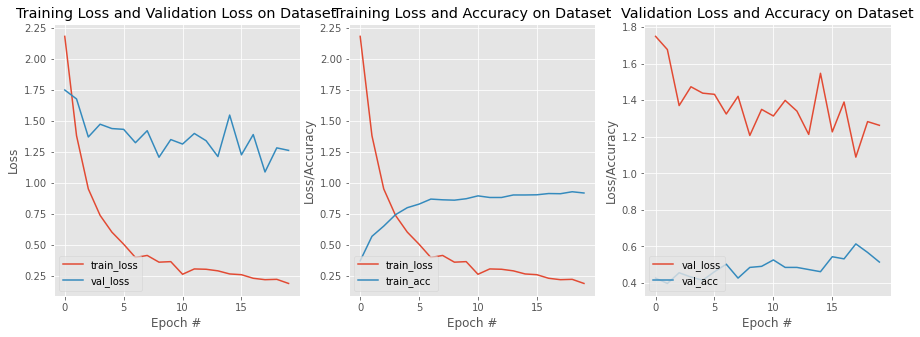

In [17]:
trained_model_s, train_generator,validation_generator = train_model(model)
label_dict_s = get_label_dict(train_generator)

In [18]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c :
            txt += '['+ str(confidence) +']'
    #print("count="+str(len(pred_class)) + " txt:" + txt)
    return txt

In [19]:
def predict(  model, video_path, filename, label_dict ):
    
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    
    # if (vs.isOpened()== False):
    #   print("Error opening video stream or file")
    # # Read until video is completed
    # while(vs.isOpened()):
    #   # Capture frame-by-frame
    #   ret, frame = vs.read()
    #   if ret == True:
    #     # Display the resulting frame
    #     cv2.imshow('Frame',frame)
    #     # Press Q on keyboard to  exit
    #     if cv2.waitKey(25) & 0xFF == ord('q'):
    #       break
    #   # Break the loop
    #   else:
    #     break
    # # When everything done, release the video capture object
    # vs.release()
    # # Closes all the frames
    # cv2.destroyAllWindows()



    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
       
        resized_frame = cv2.resize(frame, (244, 244))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        print(pred_vec)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
        else:
            pred_class.append( (0, 0) )
        if pred_class:
            txt = get_display_string(pred_class, label_dict)       
            frame = draw_prediction( frame, txt )
        print(pred_class)
        plt.axis('off')
        plt.imshow(frame)
        plt.show()
        clear_output(wait = True)
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
            # cv2.imshow('Frame',writer)

            # cv2.waitKey(25)
        # write the out
        writer.write(frame)
        
        writer.release()
    vs.release()   

        
    
      
   

In [22]:
video_path = '/content/drive/MyDrive/DATA/input/data/video_data/test_videos/test1.mp4'
predict ( trained_model_s, video_path, 'test1_9.avi',  label_dict_s) 



[[0.24991946 0.22604828 0.5240323 ]]
[(2, 0.52)]


KeyboardInterrupt: ignored